In [1]:
!pip install kmodes

In [2]:
!pip install prince 

In [3]:
!pip install plotly --upgrade

     |████████████████████████████████| 26.5 MB 54.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [7]:
!pip install boto3

In [9]:
import pandas as pd 
import numpy as np
import plotly.io as pio
import os
import io
import pathlib 
import tensorflow as tf 
import random
import tqdm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import  silhouette_score

from kmodes.kprototypes import KPrototypes
from prince import FAMD
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio
pio.renderers.default = "colab"
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import Model
from tensorflow.keras.layers import Dot, Embedding, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [10]:
df = pd.read_csv("/content/winemag-data-130k-v2.csv")
df.drop('Unnamed: 0', axis = 1, inplace = True)#On supprime la colonne Unnamed:0 qui est inutile 
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [ ]:
import re
def findyear (val):
  year=re.findall('\d{4}',val)# on créé une fonction qui extrait les années qui sont constitués de 4 chiffres 
  return year

df['years']=df['title'].apply(findyear)# on applique cette fonction sur la colonne title 
df=df.explode('years')# on créé une nouvelle colonne years qui va regrouper ttes les anneés extraites de la colonne title 
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,years
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012


In [ ]:
df = df.dropna(subset=['years'])
df = df.dropna(subset=['country'])
df = df.dropna(subset=['price'])
df = df.dropna(subset=['province'])
df = df.dropna(subset=['variety'])
df['years']=df['years'].astype(int)
# On supprime les valeurs manaquantes grace au dropna et on définit la colonne df['years ] comme une colonne qui contient des entiers 

In [ ]:
df = df[(df['years']>=1990)&(df['years']<=2021)]
# on fait un masque on ne prend que les années qui sont dans l'intervale 1990 et 2021 les autres années ne sont pas significatifs 

In [ ]:
df.drop_duplicates(keep='last', inplace=True)
# On supprime les doublons 

In [ ]:
df2 = df[['country', 'description','points', 'price', 'province', 'title','variety', 'winery', 'years']]
df2

,country,description,points,price,province,title,variety,winery,years
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011
...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2013
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2004
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2012


In [ ]:
df2.to_csv(r'final_wine_dataset.csv', index=False)

In [ ]:
df2.shape

(107647, 9)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107647 entries, 1 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      107647 non-null  object 
 1   description  107647 non-null  object 
 2   points       107647 non-null  int64  
 3   price        107647 non-null  float64
 4   province     107647 non-null  object 
 5   title        107647 non-null  object 
 6   variety      107647 non-null  object 
 7   winery       107647 non-null  object 
 8   years        107647 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 8.2+ MB


In [ ]:
df2.isna().sum()

country        0
description    0
points         0
price          0
province       0
title          0
variety        0
winery         0
years          0
dtype: int64

In [ ]:
df2.describe(include="all")

,country,description,points,price,province,title,variety,winery,years
count,107647,107647,107647.000000,107647.000000,107647,107647,107647,107647,107647.000000
unique,42,107620,NaN,NaN,415,107291,679,15462,NaN
top,US,"Stalky aromas suggest hay and green herbs, wit...",NaN,NaN,California,Domaine Sautereau 2014 Côte de Reigny (Sancerre),Pinot Noir,Williams Selyem,NaN
freq,49367,2,NaN,NaN,32941,3,11707,204,NaN
mean,NaN,NaN,88.448958,35.677697,NaN,NaN,NaN,NaN,2010.652624
std,NaN,NaN,3.098179,41.874817,NaN,NaN,NaN,NaN,3.606294
min,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,1990.000000
25%,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,2009.000000
50%,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,2011.000000
75%,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,2013.000000


Visualisation: 

In [ ]:
data=df2.groupby(['country'],as_index=False).agg({'price':'mean','points':'mean','title':'count','description':'count','variety':'count'})
data.head()
# on indique à groupby qu'on ne souhaite pas définir country comme une colonne d'index puis on va faire un ensemble d'aggregate 

,country,price,points,title,description,variety
0,Argentina,24.651646,86.675621,3462,3462,3462
1,Armenia,14.500000,87.500000,2,2,2
2,Australia,35.319220,88.575167,2102,2102,2102
3,Austria,31.302716,90.240815,2504,2504,2504
4,Bosnia and Herzegovina,12.500000,86.500000,2,2,2


In [ ]:
list_country=data['country'].tolist()
# on met la colonne country dans une liste 

In [ ]:
data_iso= pd.read_csv('/content/coutriesdf.csv')
data_iso.head()
# a travers ce fichier on peut récupérer le iso_alpha pr chaque pays 


,country,title,points,price,variety,iso_alpha,price_grade,points_grade,title_grade,Variety_grade
0,Argentina,3456,86.739294,24.618907,66,ARG,Cheap,Not good,Very Numerous,Very much
1,Armenia,2,87.500000,14.500000,2,ARM,Very cheap,Not so good,Not much,Not much
2,Australia,2100,88.602064,35.183939,63,AUS,Very Expensive,Good,Very Numerous,Very much
3,Austria,2498,90.210906,30.800289,53,AUT,Very Expensive,Very Good,Very Numerous,Very much
4,Bosnia and Herzegovina,2,86.500000,12.500000,2,BIH,Very cheap,Not good,Not much,Not much


In [ ]:
data_iso=data_iso.loc[data_iso['country'].isin(list_country)]#on ne récupère que la liste des pays qui se trouve dans list_country 
data_iso=data_iso.iloc[:,5]# on affiche toutes les lignes de la colonne 5 qui est iso_alpha 
data_iso

0     ARG
1     ARM
2     AUS
3     AUT
4     BIH
5     BRA
6     BGR
7     CAN
8     CHL
9     CHN
10    HRV
11    CYP
12    CZE
13    GBR
14    FRA
15    GEO
16    DEU
17    GRC
18    HUN
19    IND
20    ISR
21    ITA
22    LBN
23    LUX
24    MKD
25    MEX
26    MDA
27    MAR
28    NZL
29    PER
30    PRT
31    ROU
32    SRB
33    SVK
34    SVN
35    ZAF
36    ESP
37    CHE
38    TUR
39    USA
40    UKR
41    URY
Name: iso_alpha, dtype: object

In [ ]:
result = pd.concat([data_iso,data], axis=1, join='inner')
result.head()
# on fait une jointure de cette colonne avec data 

,iso_alpha,country,price,points,title,description,variety
0,ARG,Argentina,24.651646,86.675621,3462,3462,3462
1,ARM,Armenia,14.500000,87.500000,2,2,2
2,AUS,Australia,35.319220,88.575167,2102,2102,2102
3,AUT,Austria,31.302716,90.240815,2504,2504,2504
4,BIH,Bosnia and Herzegovina,12.500000,86.500000,2,2,2


In [ ]:
result.describe()

,price,points,title,description,variety
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,26.452725,87.728735,2563.023810,2563.023810,2563.023810
std,12.171225,1.647394,8114.682635,8114.682635,8114.682635
min,8.800000,83.562500,1.000000,1.000000,1.000000
25%,18.015625,86.916667,10.250000,10.250000,10.250000
50%,24.597252,87.729190,70.500000,70.500000,70.500000
75%,31.047349,88.680180,1219.000000,1219.000000,1219.000000
max,72.833333,91.893617,49367.000000,49367.000000,49367.000000


In [ ]:
def Cat_points(row):
    if row.points >= 89:
        return "very good quality"
    elif row.points >= 87:
        return "good quality"
    elif row.points >= 86:
        return "medium quality"
    else:
        return "bad quality"
    
catpoints_Results =  result.apply(Cat_points, axis='columns')

# On créer une fonction qui nous permet de faire une classification en fonction des notes attribuées et on l'applique à notre dataframe result

In [ ]:
result['quality'] = catpoints_Results
# On créé une nouvelle colonne qui contient la classification pr chaque note 

In [ ]:
def Cat_price(row):
    if row.price >= 72:
        return "very expensive"
    elif row.price >= 35:
        return "expensive"
    elif row.price >= 15:
        return "affordable"   
    else:
        return "cheap"
    
catprice_Results =  result.apply(Cat_price, axis='columns')
# On fait une autre classification pr le prix 

In [ ]:
result['cat_price'] = catprice_Results
result.loc[:,['iso_alpha','country','price','points','title','description','variety','quality','cat_price']]
result.head()

,iso_alpha,country,price,points,title,description,variety,quality,cat_price
0,ARG,Argentina,24.651646,86.675621,3462,3462,3462,medium quality,affordable
1,ARM,Armenia,14.500000,87.500000,2,2,2,good quality,cheap
2,AUS,Australia,35.319220,88.575167,2102,2102,2102,good quality,expensive
3,AUT,Austria,31.302716,90.240815,2504,2504,2504,very good quality,affordable
4,BIH,Bosnia and Herzegovina,12.500000,86.500000,2,2,2,medium quality,cheap


In [ ]:
fig1=px.choropleth(result, locations="iso_alpha",
                    color="quality",
                    hover_name="country",
                    hover_data=['title','description','variety','quality','cat_price'],
                    color_continuous_scale="Viridis",
                    title="Wine mondial carte")
fig1.show()
# On créé notre carte de vin mondiale selon la qualité du vin 

In [ ]:
fig2=px.choropleth(result, locations="iso_alpha",
                    color="cat_price",
                    hover_name="country",
                    hover_data=['title','description','variety','quality','cat_price'],
                    color_continuous_scale="Viridis",
                    title="Wine mondial carte")
fig2.show()
# On crée notre carte de vin selon les niveaux de prix 

In [ ]:
#Quels pays a le plus de titres de vin 
data_country=result.sort_values(by=['title'], ascending=False)
data_country_10= data_country.iloc[0:10,:]
data_country_10

,iso_alpha,country,price,points,title,description,variety,quality,cat_price
39,USA,US,36.958231,88.595722,49367,49367,49367,good quality,expensive
14,FRA,France,41.411486,88.753148,15009,15009,15009,good quality,expensive
21,ITA,Italy,40.917718,88.734229,14742,14742,14742,good quality,expensive
36,ESP,Spain,28.709625,87.279441,5579,5579,5579,good quality,affordable
30,PRT,Portugal,24.004223,88.305256,4262,4262,4262,good quality,affordable
8,CHL,Chile,20.835323,86.473569,4105,4105,4105,medium quality,affordable
0,ARG,Argentina,24.651646,86.675621,3462,3462,3462,medium quality,affordable
3,AUT,Austria,31.302716,90.240815,2504,2504,2504,very good quality,affordable
2,AUS,Australia,35.319220,88.575167,2102,2102,2102,good quality,expensive
16,DEU,Germany,43.571576,89.884755,1935,1935,1935,very good quality,expensive


In [ ]:
import plotly.express as px
fig3 = px.bar(data_country_10, x='country', y='title', color='country')
fig3.show()

In [ ]:
fig4= px.scatter_geo(data_country_10, locations="iso_alpha",
                     color="country", # which column to use to set the color of markers
                     hover_name="country", # column added to hover information
                     hover_data=["title","price","points","description"],
                     size="title", # size of markers
                     projection="natural earth")
fig4.show()

In [ ]:
#Quels pays a le plus de critiques de vin 
data_country=result.sort_values(by=['description'], ascending=False)
data_country_10= data_country.iloc[0:10,:]
total=data_country_10["description"].sum()
data_country_10["pourcentage"]=data_country_10["description"]/total
data_country_10

,iso_alpha,country,price,points,title,description,variety,quality,cat_price,pourcentage
39,USA,US,36.958231,88.595722,49367,49367,49367,good quality,expensive,0.478980
14,FRA,France,41.411486,88.753148,15009,15009,15009,good quality,expensive,0.145624
21,ITA,Italy,40.917718,88.734229,14742,14742,14742,good quality,expensive,0.143033
36,ESP,Spain,28.709625,87.279441,5579,5579,5579,good quality,affordable,0.054130
30,PRT,Portugal,24.004223,88.305256,4262,4262,4262,good quality,affordable,0.041352
8,CHL,Chile,20.835323,86.473569,4105,4105,4105,medium quality,affordable,0.039828
0,ARG,Argentina,24.651646,86.675621,3462,3462,3462,medium quality,affordable,0.033590
3,AUT,Austria,31.302716,90.240815,2504,2504,2504,very good quality,affordable,0.024295
2,AUS,Australia,35.319220,88.575167,2102,2102,2102,good quality,expensive,0.020395
16,DEU,Germany,43.571576,89.884755,1935,1935,1935,very good quality,expensive,0.018774


In [ ]:
fig5= px.bar(data_country_10, x='country', y='description', color='country')
fig5.show()
#L'Amérique a le plus de commentaires 49 367 soit 48% du dataset ceci n'estpas étonnant puisque le dataset est issue de WineEnthusiast, une entreprise basée à New York.
#la France est en 2ème position avec 14.5%, l'Italie 14%, Spain 5% 

In [ ]:
fig6= px.scatter_geo(data_country_10, locations="iso_alpha",
                     color="country", # which column to use to set the color of markers
                     hover_name="country", # column added to hover information
                     hover_data=["title","price","points","description"],
                     size="description", # size of markers
                     projection="natural earth")
fig6.show()

In [ ]:
#D'où vient le vin le plus cher 
data_price=result.sort_values('price',ascending=False)
data_price_10=data_price.iloc[0:10]
data_price_10

,iso_alpha,country,price,points,title,description,variety,quality,cat_price
37,CHE,Switzerland,72.833333,88.500000,6,6,6,good quality,very expensive
13,GBR,England,53.829787,91.893617,47,47,47,very good quality,expensive
16,DEU,Germany,43.571576,89.884755,1935,1935,1935,very good quality,expensive
18,HUN,Hungary,42.722222,89.349206,126,126,126,very good quality,expensive
14,FRA,France,41.411486,88.753148,15009,15009,15009,good quality,expensive
21,ITA,Italy,40.917718,88.734229,14742,14742,14742,good quality,expensive
39,USA,US,36.958231,88.595722,49367,49367,49367,good quality,expensive
7,CAN,Canada,35.789238,89.313901,223,223,223,very good quality,expensive
2,AUS,Australia,35.319220,88.575167,2102,2102,2102,good quality,expensive
20,ISR,Israel,31.798673,88.471239,452,452,452,good quality,affordable


In [ ]:
fig7= px.bar(data_price_10, x='country', y='price', color='country')
fig7.show()

In [ ]:
fig8= px.scatter_geo(data_price_10, locations="iso_alpha",
                     color="country", # which column to use to set the color of markers
                     hover_name="country", # column added to hover information
                     hover_data=["title","price","points","description"],
                     size="price", # size of markers
                     projection="natural earth")
fig8.show()

In [ ]:
# D'où vient le meilleur vin ? 
data_points=result.sort_values('points',ascending=False)
data_points_10=data_points.iloc[0:10]
data_points_10

,iso_alpha,country,price,points,title,description,variety,quality,cat_price
13,GBR,England,53.829787,91.893617,47,47,47,very good quality,expensive
19,IND,India,13.750000,90.250000,8,8,8,very good quality,cheap
3,AUT,Austria,31.302716,90.240815,2504,2504,2504,very good quality,affordable
16,DEU,Germany,43.571576,89.884755,1935,1935,1935,very good quality,expensive
18,HUN,Hungary,42.722222,89.349206,126,126,126,very good quality,expensive
7,CAN,Canada,35.789238,89.313901,223,223,223,very good quality,expensive
9,CHN,China,18.000000,89.000000,1,1,1,very good quality,affordable
23,LUX,Luxembourg,22.500000,89.000000,2,2,2,very good quality,affordable
14,FRA,France,41.411486,88.753148,15009,15009,15009,good quality,expensive
21,ITA,Italy,40.917718,88.734229,14742,14742,14742,good quality,expensive


In [ ]:
fig9= px.bar(data_points_10, x='country', y='points', color='country')
fig9.show()

In [ ]:
fig10 = px.scatter_geo(data_points_10, locations="iso_alpha",
                     color="country", # which column to use to set the color of markers
                     hover_name="country", # column added to hover information
                     hover_data=["title","price","points","description"],
                     size="points", # size of markers
                     projection="natural earth")
fig10.show()

On passe à la partie clustering: I) KPrototypes:c'est un modèle de clustering qui traite des vles numériques et catégoriques à la fois
II) FAMD: c'est une méthode qui va nous permettre de faire de la réduction de dimensions on prends tous les features de notre dataset mis à part la colonne description par la suite on passe par le kmeans pr faire du clustering

I) KPrototypes:

In [ ]:
# On a un dataset composé de 4 features, la colonne titre va nous permettre d'assigner un cluster à chaque titre 
wine_dataset = df[['points','title','variety','years']]
wine_dataset.shape

(107647, 4)

In [ ]:
wine_dataset.drop_duplicates(keep='last', inplace=True)
wine_dataset.shape
# Comme on a réduit le nbre de colonne onn va avoir d'autres doublons qui vont apparaitre c'est pr ça qu'on doit les supprimer 

(107616, 4)

In [ ]:
wine_dataset=wine_dataset.iloc[:10000,:]
wine_dataset.shape

(10000, 4)

In [ ]:
# wine_dataset_clu fait référence au 3 features pr lesquels on veut faire du clustering 
wine_dataset_clu = wine_dataset[['points','variety','years']]
wine_dataset_clu.shape

(10000, 3)

In [ ]:
wine_dataset_clu.head()

,points,variety,years
1,87,Portuguese Red,2011
2,87,Pinot Gris,2013
3,87,Riesling,2013
4,87,Pinot Noir,2012
5,87,Tempranillo-Merlot,2011


In [ ]:
wine_dataset_clu["years"]=wine_dataset_clu["years"].astype(str)
wine_dataset_clu.info()
# On transforme l'année en vble catégorique 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 12935
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   points   10000 non-null  int64 
 1   variety  10000 non-null  object
 2   years    10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


In [ ]:
# Création du pipeline pour les variables quantitatives
numeric_features = [0] # Positions des colonnes quantitatives dans X
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # pour normaliser les variables quantitatives 
])

# Création du pipeline pour les variables catégorielles
categorical_features = [1,2] # Positions des colonnes catégorielles dans X
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # on encode les catégories sous forme de colonnes comportant des 0 et des 1
    ])

# On combine les pipelines dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings sur le dataset
print("Preprocessing sur le train set...")
print(wine_dataset_clu.head())
X = preprocessor.fit_transform(wine_dataset_clu) # fit_transform !!
print('...Terminé.')
print(X[0:5, :])
print()

Preprocessing sur le train set...
   points             variety years
1      87      Portuguese Red  2011
2      87          Pinot Gris  2013
3      87            Riesling  2013
4      87          Pinot Noir  2012
5      87  Tempranillo-Merlot  2011
...Terminé.
  (0, 0)	-0.4363007771116143
  (0, 215)	1.0
  (0, 355)	1.0
  (1, 0)	-0.4363007771116143
  (1, 207)	1.0
  (1, 357)	1.0
  (2, 0)	-0.4363007771116143
  (2, 233)	1.0
  (2, 357)	1.0
  (3, 0)	-0.4363007771116143
  (3, 210)	1.0
  (3, 356)	1.0
  (4, 0)	-0.4363007771116143
  (4, 283)	1.0
  (4, 355)	1.0



In [ ]:
cost = []
for cluster in range(1,10):
    print('{cluster}\.cluster start'.format(cluster=cluster))
    kproto = KPrototypes(n_clusters = cluster, init='Huang',n_jobs=-1,n_init=10,verbose=1)
    kproto.fit(wine_dataset_clu, categorical=[1,2])
    cost.append(kproto.cost_) 

1\.cluster start
Best run was number 1
2\.cluster start
Best run was number 1
3\.cluster start
Best run was number 5
4\.cluster start
Best run was number 2
5\.cluster start
Best run was number 2
6\.cluster start
Best run was number 1
7\.cluster start
Best run was number 6
8\.cluster start
Best run was number 8
9\.cluster start
Best run was number 5


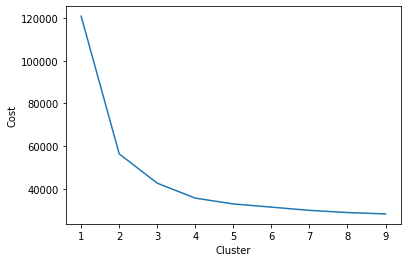

In [ ]:
plt.plot(range(1,10),cost)
plt.xlabel('Cluster')
plt.ylabel('Cost')
plt.show()



In [ ]:
kproto = KPrototypes(n_clusters = 4, init='Huang',n_jobs=-1,n_init=10,verbose=1)
kproto.fit(wine_dataset_clu, categorical=[1,2])
#centroids  -> clusters, features
centroids = kproto.cluster_centroids_
labels  = kproto.labels_

Best run was number 8


In [ ]:
wine_dataset['Cluster_kprototypes'] = labels
wine_dataset.tail()

,points,title,variety,years,Cluster_kprototypes
12931,90,Kirkland Signature 2011 Pinot Noir (Carneros),Pinot Noir,2011,1
12932,90,Les Vignerons de Tautavel Vingrau 2009 Les Vin...,Rhône-style Red Blend,2009,1
12933,90,Domaine Thunevin-Calvet 2008 Les Dentelles Red...,Rhône-style Red Blend,2008,1
12934,90,Tommasi 2009 Amarone della Valpolicella Classico,Red Blend,2009,1
12935,90,Le Salette 2010 I Progni (Valpolicella Classi...,Red Blend,2010,1


In [ ]:
wine_dataset["Cluster_kprototypes"].value_counts()

2    3624
1    2829
0    1870
3    1677
Name: Cluster_kprototypes, dtype: int64

In [ ]:
# Visualisation bi-dimensionnelle
fig = px.scatter_3d(wine_dataset,x = wine_dataset.years, y =wine_dataset.points,z=wine_dataset.variety,color = wine_dataset.Cluster_kprototypes,size=wine_dataset.points)
fig.show()

II)FAMD : Réduction de dimension

In [ ]:
#On prende une nouvelle dataset avec tous les features sauf la colonne descrption 
wine_dataset_FAMD = df[['country','points', 'price', 'province','variety', 'winery', 'years']]
wine_dataset_FAMD.shape

(107647, 7)

In [ ]:
wine_dataset_FAMD=wine_dataset_FAMD.iloc[:10000,:]
wine_dataset_FAMD.shape

(10000, 7)

In [ ]:
df2=df2.iloc[:10000,:]
df2.shape

(10000, 9)

In [ ]:
wine_dataset_FAMD.head(2)

,country,points,price,province,variety,winery,years
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos,2011
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm,2013


In [ ]:
wine_dataset_FAMD["years"]=wine_dataset_FAMD["years"].astype(str)

In [ ]:
import prince 
famd = prince.FAMD(n_components=3,random_state=0)
famd = famd.fit(wine_dataset_FAMD)

In [ ]:
famd_column=pd.DataFrame(famd.column_correlations(wine_dataset_FAMD))
famd_column.columns=['c1', 'c2', 'c3']
famd_column=famd_column.sort_values('c1', ascending=False)
famd_column.head(10)
# ça nous permet d'avoir une idée sur la corrélation entre chaque features avec les 3 composantes qui résument l'information

,c1,c2,c3
price,0.997862,0.999931,0.991206
points,0.471889,0.402793,0.529981
winery_Château Margaux,0.415592,0.428712,0.402284
winery_Château Mouton Rothschild,0.282118,0.290715,0.273361
winery_Château Haut-Brion,0.259951,0.267701,0.252032
winery_Château La Mission Haut-Brion,0.238018,0.244648,0.231176
province_Burgundy,0.148685,0.148733,0.148260
winery_Robert Weil,0.139868,0.142182,0.137268
winery_Domaine Leflaive,0.139723,0.140681,0.138277
winery_Louis Latour,0.137485,0.139360,0.135301


In [ ]:
data_famd=famd.row_coordinates(wine_dataset_FAMD)
data_famd.columns=['c1', 'c2', 'c3']
data_famd

,c1,c2,c3
1,-1.508126,1.708587,3.151341
2,-0.334536,-0.455234,-0.016540
3,-0.363266,-0.197076,0.233301
4,0.374368,-0.296805,0.018741
5,-0.780872,0.747631,-1.609791
...,...,...,...
12921,0.778547,-0.226994,-0.043895
12922,0.378575,-0.341668,-0.116402
12923,1.195541,-0.002066,0.438247
12926,0.962223,-0.059388,0.430130


In [ ]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K 
# Let's use .inertia_ parameter to get the within sum of square value for each value K 
wcss =  []
k = []
for i in range (1,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(data_famd)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))

WCSS for K=1 --> 29671.66205400709
WCSS for K=2 --> 23018.500036860616
WCSS for K=3 --> 17175.722345671235
WCSS for K=4 --> 13603.454270964468
WCSS for K=5 --> 11659.158712749371
WCSS for K=6 --> 9953.728426195572
WCSS for K=7 --> 8568.48855427008
WCSS for K=8 --> 7571.659286379832
WCSS for K=9 --> 6803.225522604391
WCSS for K=10 --> 6170.647694736583


In [ ]:
# Let's visualize using plotly
import plotly.express as px

# Create DataFrame
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

# Create figure
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
fig.show(renderer="colab")

In [ ]:
# Import silhouette score
from sklearn.metrics import silhouette_score

# Computer mean silhouette score
sil = []
k = []

## on doit commencer par i=2 car le score de silhouette regarde pr un pt donnée à quel pt il est proche de son centroide et éloigné 
# du cluster le plus proche
for i in range (2,11):
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(data_famd)
    sil.append(silhouette_score(data_famd, kmeans.predict(data_famd))) # il attend la valeur du feature et à quel cluster j'ai assigné ce feature 
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

Silhouette score for K=2 is 0.6534518289103551
Silhouette score for K=3 is 0.37520014716555095
Silhouette score for K=4 is 0.37689839354364424
Silhouette score for K=5 is 0.31632844604606963
Silhouette score for K=6 is 0.3183891472729159
Silhouette score for K=7 is 0.3253662258578191
Silhouette score for K=8 is 0.3167014012059227
Silhouette score for K=9 is 0.31947544835172376
Silhouette score for K=10 is 0.33419235120593777


In [ ]:
# Create a data frame 
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,  
             x=k, 
             y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
fig.show(renderer="colab") 

In [ ]:
# On ré-entraîne un KMeans avec le nombre optimal de clusters
kmeans = KMeans(n_clusters= 3)
kmeans.fit(data_famd)

KMeans(n_clusters=3)

In [ ]:
#On reprend le dataset précédent la réduction de dimension
df2.loc[:,'Cluster_KMeans'] = kmeans.predict(data_famd)
df2.head()

,country,description,points,price,province,title,variety,winery,years,Cluster_KMeans
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,2
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,0
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,0
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,1
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,0


In [ ]:
df2["Cluster_KMeans"].value_counts()

0    5336
1    4196
2     468
Name: Cluster_KMeans, dtype: int64

In [ ]:
gp_variety=pd.concat([df2,data_famd], axis=1)
gp_variety.head()

,country,description,points,price,province,title,variety,winery,years,Cluster_KMeans,c1,c2,c3
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,2,-1.508126,1.708587,3.151341
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,0,-0.334536,-0.455234,-0.016540
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,0,-0.363266,-0.197076,0.233301
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,1,0.374368,-0.296805,0.018741
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,0,-0.780872,0.747631,-1.609791


In [ ]:
gp_variety_2=gp_variety.groupby(['Cluster_KMeans'],as_index=False).agg({'c1':'mean','c2':'mean','c3':'mean'})
gp_variety_2.head()

,Cluster_KMeans,c1,c2,c3
0,0,-0.602958,-0.011584,-0.353405
1,1,0.896356,-0.176928,0.110495
2,2,-1.161810,1.718373,3.038745


In [ ]:
fig = px.scatter_3d( gp_variety,x = gp_variety["c1"], y =gp_variety["c2"],z=gp_variety["c3"], color=gp_variety["Cluster_KMeans"])
fig.show()

Nous allons créer un système de recommandations de vin selon les descripteurs qui se trouvent dans les critiques de vin.


**1. Extraction des descripteurs de vin**

Pour commencer cette analyse, nous devons extraire des descripteurs de nos revues et créer une catégorisation de ces descripteurs à différents niveaux de spécificité. Ici, nous nous sommes inspirés des travaux de Bernard Chen sur la roue du vin (https://www.springerprofessional.de/en/the-computational-wine-wheel-2-0-and-the-trimax-tricluster-in/10290536).

Les descripteurs sont extraits en quelques étapes, décrites dans les cellules ci-dessous : d'abord, toutes les critiques de vins sont regroupées en un seul grand corpus. Ils sont ensuite traités en phrases.



In [ ]:
 #Après le clustering je reviens avec le dataset qui reprend les éléments suivants:
 wine_dataset=df2
 wine_dataset.shape

(107647, 9)

In [ ]:
wine_dataset.head()

,country,description,points,price,province,title,variety,winery,years
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011


In [ ]:
reviews_list = list(wine_dataset['description'])# on met tte la colonne description dans une liste 
reviews_list = [str(r) for r in reviews_list]# On a transformé chaque ligne en chaine de caractère 
full_corpus = ' '.join(reviews_list)# On a joint ttes les chaines de caractères précédentes pour former un seul et unique document 
sentences_tokenized = sent_tokenize(full_corpus)#puis on sépare ce document en phrases 

print(sentences_tokenized[:1])

['This is ripe and fruity, a wine that is smooth while still structured.']


In [ ]:
word_tokenize(str(sentences_tokenized[:1]))

['[',
 "'This",
 'is',
 'ripe',
 'and',
 'fruity',
 ',',
 'a',
 'wine',
 'that',
 'is',
 'smooth',
 'while',
 'still',
 'structured',
 '.',
 "'",
 ']']

In [ ]:
#On commence par nettoyer le texte (lemmatisation, suppression ponctuation et stopwords)

stop_words = set(stopwords.words('english')) # comme on travaille avec NLTK on importe les stop_words 

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')
def cleaning(raw_text):
    try:
        word_list = word_tokenize(raw_text)# word_tokenize sert à séparer une phrase en un ensemble de mots 
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)# on transforme le mot en minisucle 
                stemmed_word = sno.stem(lower_case_word)# c'est l'équivalent de la lemmatisation, on garde la racine du mot 
                no_punctuation = stemmed_word.translate(punctuation_table)# On supprime la ponctuation 
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:#on fait un filtre qui nous évite de prendre la ponctuation
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return normalized_sentence
    except:
        return ''

normalized_sentences = []
for s in sentences_tokenized:
    normalized_text = cleaning(s)
    normalized_sentences.append(normalized_text)

#On créé une liste normalized_sentences où on applique le préprocessing à ttes les phrases du corpus 

In [ ]:
#phrases=Phrases(normalized_sentences[0])
#print(phrases)

Phrases<39 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [ ]:
#Certains termes ne sont pas forcément composé d'un mot mais de deux voire plus par exemple :'high_tannin'.
#On peut utiliser gensim pour extraire les bi- et tri-grams les plus pertinents depuis notre corpus

phrases = Phrases(normalized_sentences)#Détecte automatiquement les expressions courantes càd les n-grammes - à partir d'un flux de phrases.
phrases = Phrases(phrases[normalized_sentences])

ngrams = Phraser(phrases)

phrased_sentences = []
for sent in normalized_sentences:
    phrased_sentence = ngrams[sent]
    phrased_sentences.append(phrased_sentence)

full_list_words = [item for sublist in phrased_sentences for item in sublist]
#ça sert à applatir une liste de liste pour récupérer une liste de tous les mots

In [ ]:
#On voit si notre modèle marche s'il arrive à détecter les bi et les tri-grams 
#phrased_sentences[2]

['alreadi_drinkabl', 'although', 'certain', 'better_2016']

In [ ]:
#list_of_lists = [(1,2,3),(2,3,4),(3,4,5)]
#[item for sublist in list_of_lists for item in sublist]

[1, 2, 3, 2, 3, 4, 3, 4, 5]

In [ ]:
# Extraire les mots les plus communs et les classer par fréquence d'apparition
word_counts = Counter(full_list_words)#ça nous permet de compter la fréquence d'apparition d'un mot
sorted_counts = OrderedDict(word_counts.most_common(5000))#ça nous permet de classer par ordre décroissant et de séléctionner les 5000 mots les plus fréquents
counter_df = pd.DataFrame.from_dict(sorted_counts, orient='index')
# top_5000_words = counter_df.head(5000)
counter_df.to_csv('top_5000_descriptors.csv')#On stocke ces 5000 descripteurs dans un fichier csv 

In [ ]:
descriptor_mapping = pd.read_csv('descriptor_mapping.csv').set_index('raw descriptor')
descriptor_mapping.head(10)

,level_3,level_2,level_1
raw descriptor,,,
abras,abrasive,high_tannin,tannin
acacia,acacia,flowery,flower
acacia_flower,acacia,flowery,flower
aciddriven,acid_driven,high_acid,acid
aggress,aggressive,high_acid,acid
airi,airy,light_bodied,body
allspic,allspice,baking_spices,spice
almond,almond,nutty,nutty
almond_past,almond,nutty,nutty


In [ ]:
wine_mapping = descriptor_mapping['level_3'].unique().tolist()# On a pris le level 3 qui décrit le mieux les arômes on a appliqué unique pr supprimer la répétition des mots puis on les a stocker dans une liste
#wine_mapping

In [ ]:
#Ensuite, tous les termes du corpus qui apparaissent dans la vue d'ensemble ci-dessus sont mappés sur la couche « level_3 » (la plus spécifique) du tableau.

def return_mapped_descriptor(word):
    if word in (descriptor_mapping.index):
        normalized_word = descriptor_mapping['level_3'][word]
        return normalized_word
    else:
        return word

#On commence par définir notre fonction,le mot qui se trouve dans la colonne index et on prend son équivalent de la colonne 3
# Si le on ne trouve pas se mot dans la liste on le prend qd mm
normalized_sentences = []
for sent in phrased_sentences:
    normalized_sentence = []
    for word in sent:
        normalized_word = return_mapped_descriptor(word)
        normalized_sentence.append(str(normalized_word))
    normalized_sentences.append(normalized_sentence)
#On applique la fonction définit plus haut à notre modèle, on va mapper chaque mot qui se trouve dans nos phrases
#nettoyées et transformées. 


**2. A partir des descripteurs de vin vers  Word Embeddings**

Nous pouvons maintenant procéder à la formation d'un modèle Word2Vec sur notre corpus normalisé et cartographié par des descripteurs. Cela nous permettra d'obtenir un mot incorporé pour chaque terme du corpus. Afin de réduire la taille globale du corpus, nous exclurons tous les termes qui apparaissent moins de 5 fois dans toutes les critiques de vins.

In [ ]:
from gensim.models import word2vec

wine_word2vec_model = word2vec.Word2Vec(normalized_sentences, min_count=5)
print(wine_word2vec_model)
wine_word2vec_model.save('wine_word2vec_model.bin')

Word2Vec(vocab=14686, size=100, alpha=0.025)


In [ ]:
#Essai : quels descripteurs de vin sont les plus similaires au mot « peach » ?
wine_word2vec_model.wv.most_similar(positive='peach', topn=10)

[('stone_fruit', 0.8754190802574158),
 ('mango', 0.8030534386634827),
 ('honeydew', 0.7835456132888794),
 ('nectarine', 0.773927628993988),
 ('quince', 0.7664388418197632),
 ('tree_fruit', 0.7574886083602905),
 ('apricot', 0.7462590336799622),
 ('tangerine', 0.7393563985824585),
 ('cataloupe', 0.738781213760376),
 ('pineapple', 0.734571099281311)]

**3. From Word Embeddings to Wine Review Embeddings**


On va raisonner en terme de critique, nous allons extraire un ensemble de descripteurs cartographiés et normalisés de chaque critique de vin. Contrairement à l'époque où nous formions notre modèle Word2Vec (lorsque des mots intermédiaires pouvaient aider à créer des inc orporationsplus précises), nous supprimerons tous les descripteurs qui ne figurent pas dans notre liste de 1000 descripteurs sélectionnés. 

In [ ]:
wine_reviews = wine_dataset['description']

def return_descriptor_from_mapping(word):
    if word in descriptor_mapping.index:
        descriptor_to_return = descriptor_mapping['level_3'][word]
        return descriptor_to_return

descriptorized_reviews = []
for review in wine_reviews:
    normalized_review = cleaning(review)
    phrased_review = ngrams[normalized_review]
    descriptors_only = [return_descriptor_from_mapping(word) for word in phrased_review]
    no_nones = [str(d) for d in descriptors_only if d is not None]
    descriptorized_review = ' '.join(no_nones)
    descriptorized_reviews.append(descriptorized_review)
#On va normaliser et extraire des ngrams à chacune de nos critiques on va utiliser les fonctions qu'on a définit 
#précédemment puis on va cartographié chaque mot de nos critique uniquement s'il se trouve dans la liste des 
#indexes du descriptor_mapping, on va récuperer tous les mots sauf les mots vides les None et on va les joindre 
# afin de constituer une liste de critique 


In [ ]:
len(descriptorized_reviews)

107647

Tous les descripteurs ne sont pas également représentés "fruité" par exemple est susceptible d'apparaître très fréquemment dans toutes les critiques de vins, tandis que "réglisse" est beaucoup moins courant. En calculant review embedding nous voulons donner une pondération plus élevée aux termes qui sont moins fréquents. Nous allons le faire en multipliant chaque word embedding par une pondération TF-IDF. Cela prend en considération à la fois la fréquence de chaque terme dans toutes les critiques, ainsi que le nombre de descripteurs dans chaque critique de vin.



In [ ]:
wine_reviews=wine_dataset['description'].tolist()
wine_reviews[0]

"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016."

In [ ]:
critique=descriptorized_reviews[0]
critique.split(' ')

['ripe', 'fruit', 'smooth', 'firm', 'juicy', 'berry', 'fruit', 'fresh']

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit(descriptorized_reviews)

dict_of_tfidf_weightings = dict(zip(X.get_feature_names(), X.idf_))

wine_review_vectors = []
for d in descriptorized_reviews:
    descriptor_count = 0
    weighted_review_terms = []
    terms = d.split(' ')
    for term in terms:
        if term in dict_of_tfidf_weightings.keys():
            tfidf_weighting = dict_of_tfidf_weightings[term]
            word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 100)
            weighted_word_vector = tfidf_weighting * word_vector
            weighted_review_terms.append(weighted_word_vector)
            descriptor_count += 1
        else:
            continue
    try:
        review_vector = sum(weighted_review_terms)/len(weighted_review_terms)
    except:
        review_vector = []
    vector_and_count = [terms, review_vector, descriptor_count]
    wine_review_vectors.append(vector_and_count)

wine_dataset['normalized_descriptors'] = list(map(itemgetter(0), wine_review_vectors))
wine_dataset['review_vector'] = list(map(itemgetter(1), wine_review_vectors))
wine_dataset['descriptor_count'] = list(map(itemgetter(2), wine_review_vectors))

wine_dataset.reset_index(inplace=True)
wine_dataset.head()

#la fonction map() permet d'appliquer une fonction à chaque élément d'un itérable, il remplace la boucle for
#itemgetter nous permet de trier 

,index,country,description,points,price,province,title,variety,winery,years,normalized_descriptors,review_vector,descriptor_count
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,"[ripe, fruit, smooth, firm, juicy, berry, frui...","[[-1.077939, 2.3573332, -2.3952937, 1.623329, ...",8
1,2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,"[tart, snappy, lime, green, pineapple, crisp, ...","[[-6.550882, 4.7034955, -1.2182838, -0.2113049...",7
2,3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,"[pineapple, rind, lemon_pith, orange_blossom, ...","[[-3.129679, 0.5279395, 1.058729, -1.090408, 1...",6
3,4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,"[rough, tannin, rustic, earth, herb, hearty]","[[-1.3024083, 0.43168435, -3.6304657, -3.36025...",6
4,5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,"[blackberry, raspberry, full_bodied, tomato, s...","[[-3.2954774, 1.8894757, -2.4503794, -2.035488...",11


In [ ]:
dict_of_tfidf_weightings['ripe']

2.583379538219445

In [ ]:
wine_word2vec_model.wv.get_vector('ripe')

array([-1.5898217 ,  0.5197979 , -0.539282  ,  1.6602818 ,  3.0413415 ,
        0.49020523, -0.4116394 , -1.3324001 , -0.4050293 , -2.5250604 ,
       -0.36475617,  0.232599  ,  0.8892241 , -1.2515866 ,  0.8865371 ,
        0.22855449, -1.6876013 , -0.29697958,  1.4333732 ,  0.58431846,
       -0.90661705,  1.8278883 , -0.4634212 ,  2.815164  , -0.04717701,
       -0.5743822 , -1.0675462 , -2.1401515 , -1.1491694 , -0.569501  ,
        0.180513  , -0.65989536, -0.38458958, -0.4329849 , -0.7247937 ,
       -0.1357688 , -1.060452  ,  1.5997574 ,  1.145875  , -1.6455985 ,
       -0.6161006 , -1.1776254 , -0.13139628,  0.18997064,  2.042739  ,
       -0.44099197,  0.8514526 ,  0.9434149 , -0.5661754 ,  1.0134467 ,
        0.17470397, -1.1409186 ,  0.45484826, -0.15709068, -0.7099262 ,
        0.04346376, -0.39467257,  0.1880457 ,  0.9222145 ,  0.31419107,
       -1.8076595 ,  0.02741875, -2.7295105 , -0.86890465,  0.13366282,
        1.5485562 ,  0.37341404, -1.4929014 , -1.2363403 , -0.07

Pour résumer, nous générons un vecteur unique pour chaque critique de vin en passant par les étapes suivantes :

- Normaliser les mots dans la critique du vin (supprime les stop_words et la ponctuation,lemmatize)
- Améliorer l'ensemble des mots normalisés avec des phrases (bi-grammes et tri-grammes)
- Appliquez la cartographie des termes de vin à chaque critique, en ne conservant que les phrases et mots mappés qui ont été jugés pertinents et en les mappant à nos descripteurs de niveau 3
- Récupérer le word embedding Word2Vec pour chaque terme mappé dans la revue
- Pondérer chaque mot intégré dans la critique de vin avec une pondération TF-IDF
- Additionnez le word embedding dans chaque critique de vin pour créer une représentation vectorielle unique à la critique de vin

In [ ]:
name_test = "Quinta dos Avidagos 2011 Avidagos Red (Douro)"

wine_test_vector = wine_dataset.loc[wine_dataset['title'] == name_test]['review_vector'].tolist()[0]
wine_test_vector

array([[-1.077939  ,  2.3573332 , -2.3952937 ,  1.623329  ,  4.080646  ,
         1.9286592 ,  2.4852848 , -1.8343415 , -0.2753505 , -7.254921  ,
         0.87724125,  0.06138033,  0.99636674,  1.512606  , -0.48619288,
        -0.1716043 , -4.261903  , -1.5291399 ,  2.8989916 ,  0.56401753,
         0.8507157 ,  3.6190841 ,  4.0627246 ,  2.4505234 , -0.10708284,
        -0.27536193, -0.87457705, -0.8492727 ,  0.46312875,  0.36458254,
        -1.9165561 , -1.096592  , -0.88411874, -0.5424559 , -1.8967588 ,
        -0.35606033, -1.628307  ,  3.6936169 ,  0.78917396, -2.3033173 ,
        -2.7241979 ,  0.30605277,  1.6430862 ,  0.15509795,  0.83798116,
         0.971372  ,  3.1162014 ,  2.1352606 , -0.9480518 ,  3.5413072 ,
        -4.5498676 , -2.2753222 ,  1.1719952 ,  0.45717126, -1.9283516 ,
         0.14700675,  0.09751111, -1.5312456 ,  2.0684814 ,  1.8944004 ,
        -3.2302132 , -0.6284922 , -1.206528  , -4.1875367 , -1.8599317 ,
         2.635648  ,  1.7764862 ,  3.3479614 , -3.7

In [ ]:
def count_vect (val):
    if len(val)>0:
        x=1
    elif len(val)==0:
        x=0
    return x

wine_dataset['check_vect']=wine_dataset['review_vector'].apply(count_vect)

In [ ]:
df2=wine_dataset[wine_dataset['check_vect']==1]

In [ ]:
df2.head()

,index,country,description,points,price,province,title,variety,winery,years,normalized_descriptors,review_vector,descriptor_count,check_vect
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,"[ripe, fruit, smooth, firm, juicy, berry, frui...","[[-1.077939, 2.3573332, -2.3952937, 1.623329, ...",8,1
1,2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,"[tart, snappy, lime, green, pineapple, crisp, ...","[[-6.550882, 4.7034955, -1.2182838, -0.2113049...",7,1
2,3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,"[pineapple, rind, lemon_pith, orange_blossom, ...","[[-3.129679, 0.5279395, 1.058729, -1.090408, 1...",6,1
3,4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,"[rough, tannin, rustic, earth, herb, hearty]","[[-1.3024083, 0.43168435, -3.6304657, -3.36025...",6,1
4,5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,"[blackberry, raspberry, full_bodied, tomato, s...","[[-3.2954774, 1.8894757, -2.4503794, -2.035488...",11,1


In [ ]:
df_final= df2[df2['country']=="US"]
input_vectors = list(df_final['review_vector'])
input_vectors_listed = [a.tolist() for a in input_vectors]
input_vectors_listed = [a[0] for a in input_vectors_listed]
len(input_vectors_listed)

49343

In [ ]:
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric='cosine')
model_knn = knn.fit(input_vectors_listed)

In [ ]:
name_test = "Quinta dos Avidagos 2011 Avidagos Red (Douro)"

wine_test_vector = wine_dataset.loc[wine_dataset['title'] == name_test]['review_vector'].tolist()[0]
# wine_test_vector = test
distance, indice = model_knn.kneighbors(wine_test_vector, n_neighbors=9)
distance_list = distance[0].tolist()[1:]
indice_list = indice[0].tolist()[1:]

main_wine =wine_dataset.loc[wine_dataset['title'] == name_test]

print('Wine to match:', name_test)
print('The original wine has the following descriptors:', list(main_wine['normalized_descriptors'])[0])
print('_________')

n = 1
for d, i in zip(distance_list, indice_list):
    wine_name = wine_dataset['title'][i]
    wine_descriptors = wine_dataset['normalized_descriptors'][i]
    wine_points = wine_dataset['points'][i]
    wine_variety = wine_dataset['variety'][i]
    wine_country = wine_dataset['country'][i]
    print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
    print('This wine has the following descriptors:', wine_descriptors)
    print('This wine has the following rating:', wine_points)
    print('This wine has the following variety:', wine_variety)
    print('This wine has the following country:', wine_country)
    print('')
    n+=1

Wine to match: Quinta dos Avidagos 2011 Avidagos Red (Douro)
The original wine has the following descriptors: ['ripe', 'fruit', 'smooth', 'firm', 'juicy', 'berry', 'fruit', 'fresh']
_________
Suggestion 1 : Bridgeview 2006 Blue Moon Riesling (Oregon) with a cosine distance of 0.068
This wine has the following descriptors: ['blue', 'flashy', 'sweet', 'tropical_fruit', 'complex']
This wine has the following rating: 85
This wine has the following variety: Riesling
This wine has the following country: US

Suggestion 2 : Tenuta San Giorgio 2005 Ugolforte  (Brunello di Montalcino) with a cosine distance of 0.076
This wine has the following descriptors: ['ripe', 'plump', 'oak', 'fruit', 'blackberry', 'currant', 'spice', 'smoke', 'tar']
This wine has the following rating: 89
This wine has the following variety: Sangiovese Grosso
This wine has the following country: Italy

Suggestion 3 : Casar de Burbia 2007 Hombros Mencía (Bierzo) with a cosine distance of 0.087
This wine has the following des

In [ ]:
def descriptors_to_best_match_wines(list_of_descriptors, number_of_suggestions=10):
    weighted_review_terms = []
    for term in list_of_descriptors:
        if term not in dict_of_tfidf_weightings:
            if term not in descriptor_mapping.index:
                print('choose a different descriptor from', term)
                continue
            else:
                term = descriptor_mapping['normalized'][term]
        tfidf_weighting = dict_of_tfidf_weightings[term]
        word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 100)
        weighted_word_vector = tfidf_weighting * word_vector
        weighted_review_terms.append(weighted_word_vector)
    review_vector = sum(weighted_review_terms)
    
    distance, indice = model_knn.kneighbors(review_vector, n_neighbors=number_of_suggestions+1)
    distance_list = distance[0].tolist()[1:]
    indice_list = indice[0].tolist()[1:]

    n = 1
    for d, i in zip(distance_list, indice_list):
        wine_name = df_final['title'][i]
        wine_descriptors = df_final['normalized_descriptors'][i]
        print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
        print('This wine has the following descriptors:', wine_descriptors)
        print('')
        n+=1
    
descriptors = ['complex', 'high_acid', 'fresh', 'grass', 'lime']
descriptors_to_best_match_wines(list_of_descriptors=descriptors, number_of_suggestions=5)

Suggestion 1 : Gård 2006 Lawrence Vineyards Don Isidro Red Wine Red (Columbia Valley (WA)) with a cosine distance of 0.081
This wine has the following descriptors: ['flower', 'fruit', 'soft', 'medium_bodied', 'fruit-forward', 'plum', 'cherry', 'cocoa']

Suggestion 2 : Smith-Madrone 2006 Chardonnay (Spring Mountain District) with a cosine distance of 0.082
This wine has the following descriptors: ['dry', 'crisp', 'minerality', 'ripe', 'peach', 'pear', 'apple', 'pineapple', 'stone', 'oak', 'fruity', 'elegant']

Suggestion 3 : Callaway 2010 Winemaker's Reserve Syrah (Temecula Valley) with a cosine distance of 0.088
This wine has the following descriptors: ['blueberry', 'smoke', 'tobacco', 'blackberry', 'dark', 'plum', 'purple_flower', 'tart', 'plum']

Suggestion 4 : CrossKeys 2011 Ali d'Oro White (Virginia) with a cosine distance of 0.088
This wine has the following descriptors: ['white_flower', 'tropical_fruit', 'fruit', 'viscous', 'residual_sugar']

Suggestion 5 : Kuleto Estate 2013 Cab

**4. Explorer nos vecteurs de revue de vin**

 **4.1 Similitudes entre les cépages** 

Maintenant que nous avons une représentation vectorielle de chaque critique de vin, nous pouvons commencer 
à explorer les utilisations potentielles de ces données. Avant de nous intéresser à la création d'un moteur
de recommandation de vins, nous allons nous intéresser aux similitudes entre cépages. Pour ce faire,
nous prendrons la moyenne de tous les vecteurs de revue de vin pour chaque cépage, les comprimerons en deux 
dimensions à l'aide de l'ACP (Analyse en Composantes Principales) et réaliserons ensuite une cartographie visuelle.

In [ ]:
# On supprime les lignes qui ont moins de 5 élements décrivant les vins
df3 = df2.loc[df2['descriptor_count'] > 5]
df3.reset_index(inplace=True)

variety_mapping = {'Shiraz': 'Syrah', 'Pinot Gris': 'Pinot Grigio', 'Pinot Grigio/Gris': 'Pinot Grigio', 
                   'Garnacha, Grenache': 'Grenache', 'Garnacha': 'Grenache', 'CarmenÃ¨re': 'Carmenere',
                    'GrÃ¼ner Veltliner': 'Gruner Veltliner', 'TorrontÃ©s': 'Torrontes', 
                   'RhÃ´ne-style Red Blend': 'Rhone-style Red Blend', 'AlbariÃ±o': 'Albarino',
                  'GewÃ¼rztraminer': 'Gewurztraminer', 'RhÃ´ne-style White Blend': 'Rhone-style White Blend'}

def consolidate_varieties(variety_name):
    if variety_name in variety_mapping:
        return variety_mapping[variety_name]
    else:
        return variety_name

wine_reviews_clean = df3.copy()
wine_reviews_clean['variety'] = wine_reviews_clean['variety'].apply(consolidate_varieties)

def subset_wine_vectors(list_of_varieties):
    wine_variety_vectors = []
    for v in list_of_varieties:
        one_var_only = wine_reviews_clean.loc[wine_reviews_clean['variety'] == v]#Selection de tous les vins ayant la même variety ds df 'one_var_only'
        review_arrays = one_var_only['review_vector'].apply(lambda x: x[0])#Selection d'une seule variable (première) pour chaque vins
        average_variety_vec = np.average(review_arrays)#on calcule la moyenne sur tous les vins
        wine_variety_vector = [v, average_variety_vec]#On associe la variety à sa valeur moyenne
        wine_variety_vectors.append(wine_variety_vector)#On ajoute couple variety/valeur moyenne dans une liste
    return wine_variety_vectors

def pca_wine_variety(list_of_varieties):
    wine_var_vectors = subset_wine_vectors(list_of_varieties)#on prend le résultat de la fonction précédente
    pca = PCA(n_components=2)#On effectue une PCA pour résumer l'information sur chaque couple variety/val
    pca.fit([w[1] for w in wine_var_vectors])  
    pca_dataset = pca.fit_transform([w[1] for w in wine_var_vectors])
    pca_dataframe = pd.DataFrame(pca_dataset, columns=['pca_1', 'pca_2'])
    pca_dataframe.index = [w[0] for w in wine_var_vectors]
    # print(pca_dataframe)
    return pca_dataframe



In [ ]:
most_common_whites = ['Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Pinot Grigio', 
                        'Gruner Veltliner', 'Viognier', 'Chenin Blanc', 'Albarino', 'Pinot Blanc', 'Verdejo',
                        'Torrontes', 'Vermentino', 'Melon', 'Gewurztraminer', 'Rhone-style White Blend']

most_common_reds = ['Pinot Noir', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot',
                         'Sangiovese', 'Zinfandel', 'Tempranillo', 'Nebbiolo', 'Portuguese Red', 'Malbec',
                         'Rhone-style Red Blend', 'Cabernet Franc', 'Gamay','Tempranillo Blend, Tempranillo', 'Petite Sirah',
                        'Barbera', "Nero d'Avola, Italian Red"]

varietydf=df2['variety'].unique().tolist()

selected_white_wine=[]
selected_red_wine=[]

for i in varietydf:
    if i in most_common_whites:
        selected_white_wine.append(i)
    else:
        pass
    
for i in varietydf:
    if i in most_common_reds:
        selected_red_wine.append(i)
    else:
        pass

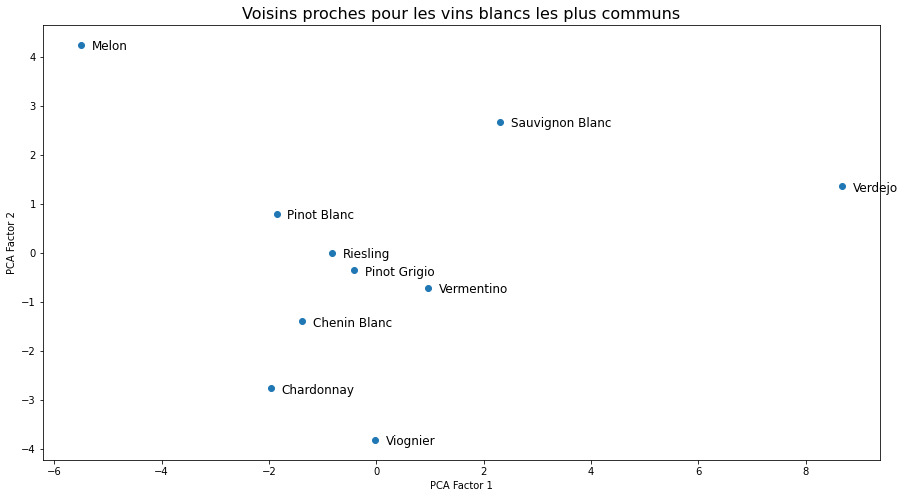

In [ ]:
pca_w_dataframe = pca_wine_variety(selected_white_wine)
plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=12)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Voisins proches pour les vins blancs les plus communs', fontsize=16)
plt.show()

In [ ]:
pca_w_dataframe

,pca_1,pca_2
Riesling,-0.827706,-0.008419
Chenin Blanc,-1.384921,-1.399390
Sauvignon Blanc,2.312352,2.677908
Chardonnay,-1.958664,-2.771158
Viognier,-0.017271,-3.825705
Vermentino,0.965627,-0.722317
Pinot Blanc,-1.853960,0.792545
Verdejo,8.674120,1.359983
Pinot Grigio,-0.409339,-0.359262
Melon,-5.500239,4.255815


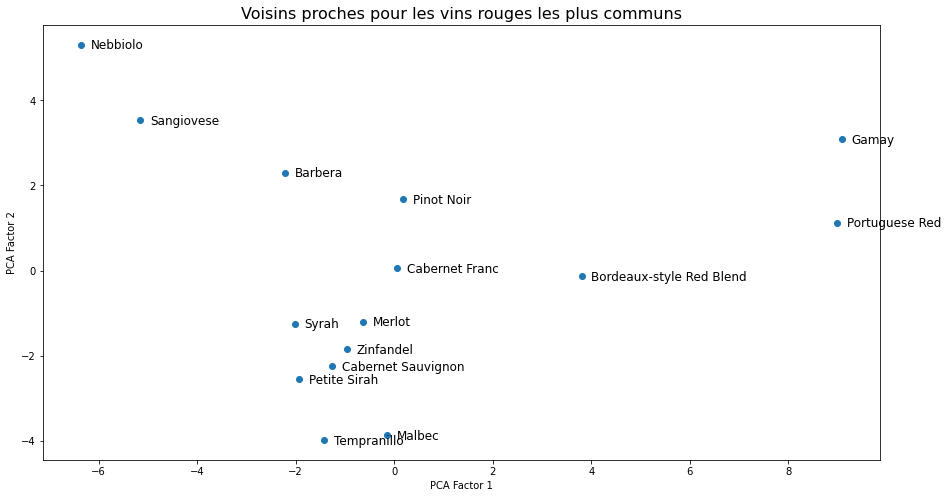

In [ ]:
pca_w_dataframe = pca_wine_variety(selected_red_wine)
plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=12)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Voisins proches pour les vins rouges les plus communs', fontsize=16)
plt.show()